# Data Augmentation
- Demonstrates how to apply data augmentation (a technique to increase the diversity of training set by applying transformations, such as image rotation)
- Full tutorial reference: https://www.tensorflow.org/tutorials/images/data_augmentation

### Import TensorFlow and necessary libraries

In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.8.2


### Download the dataset

In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


### Use Keras preprocessing layers
- Resizing and rescaling
- Data augmentation

In [4]:
img_size = 180

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(img_size, img_size),
    tf.keras.layers.Rescaling(1./255)
])

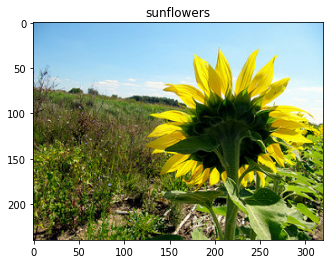

In [5]:
get_label_name = metadata.features['label'].int2str

from itertools import islice
image, label = next(islice(iter(train_ds), 2, None))
plt.figure()
plt.imshow(image)
plt.title(get_label_name(label))
plt.show()

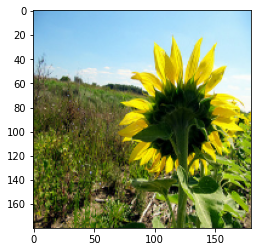

Min and max pixel values: 0.0 1.0


In [6]:
result = resize_and_rescale(image)
plt.figure()
plt.imshow(result)
plt.show()

print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

### Data Augmentation

In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomRotation(0.2)
])

In [8]:
result = tf.cast(tf.expand_dims(result, 0), tf.float32)

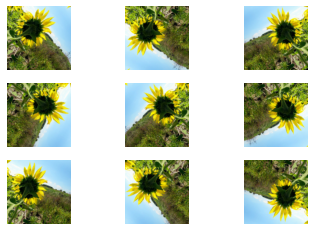

In [9]:
plt.figure()
for i in range(9):
  augmented_img = data_augmentation(result)
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(augmented_img[0])
  plt.axis('off')

plt.show()

### Two options to use the Keras preprocessing layers
1. Make the preprocessing layers part of the model
2. Apply the preprocessing layers to the dataset 

### Second option: Apply the preprocessing layers to the datasets

In [10]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

In [11]:
def preprocess(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)
  
  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [12]:
train_ds = preprocess(train_ds, shuffle=True, augment=True)
val_ds = preprocess(val_ds)
test_ds = preprocess(test_ds)

### Train the model

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Epoch 1/5
92/92 [==============================] - 109s 1s/step - loss: 1.3905 - accuracy: 0.4125 - val_loss: 1.1534 - val_accuracy: 0.5313
Epoch 2/5
92/92 [==============================] - 101s 1s/step - loss: 1.0656 - accuracy: 0.5616 - val_loss: 0.9570 - val_accuracy: 0.6294
Epoch 3/5
92/92 [==============================] - 102s 1s/step - loss: 0.9828 - accuracy: 0.6127 - val_loss: 0.9544 - val_accuracy: 0.6403
Epoch 4/5
92/92 [==============================] - 102s 1s/step - loss: 0.9362 - accuracy: 0.6362 - val_loss: 0.9362 - val_accuracy: 0.6540
Epoch 5/5
92/92 [==============================] - 101s 1s/step - loss: 0.8958 - accuracy: 0.6570 - val_loss: 0.9673 - val_accuracy: 0.6594


In [16]:
loss, acc = model.evaluate(test_ds)
print('Accuracy:', acc)

12/12 [==============================] - 5s 379ms/step - loss: 0.9470 - accuracy: 0.6049
Accuracy: 0.6049046516418457


### Using ```tf.image```
- For finer control, it is possible to write self-designed data augmentation pipelines or layers using ```tf.data``` and ```tf.image```

In [17]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
    try_gcs=True
)

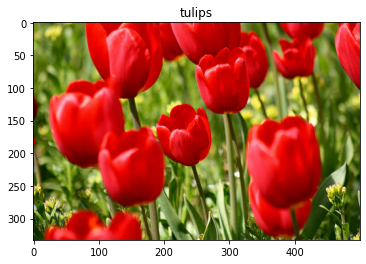

In [20]:
image, label = next(iter(train_ds))
plt.figure()
plt.imshow(image)
plt.title(get_label_name(label))
plt.show()

In [49]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)
    plt.axis('off')

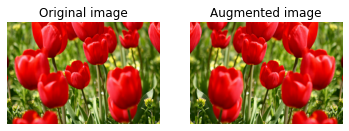

In [50]:
# Flip an image either vertically or horizontally
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

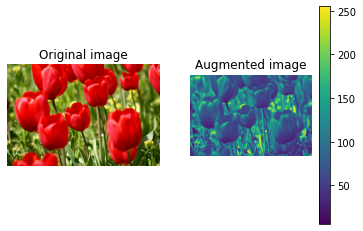

In [51]:
# Grayscale an image 
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
plt.colorbar()
plt.show()

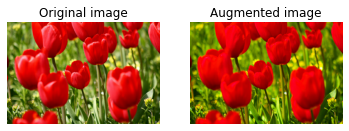

In [52]:
# Saturate an image
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

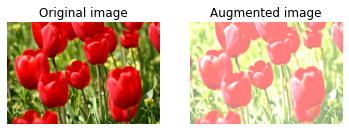

In [55]:
# Change the brightness of image
bright = tf.image.adjust_brightness(image, 0.5)
visualize(image, bright)

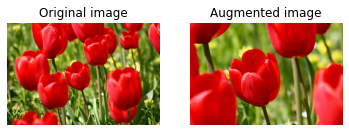

In [56]:
# Crop an image from centre up to the desired part
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

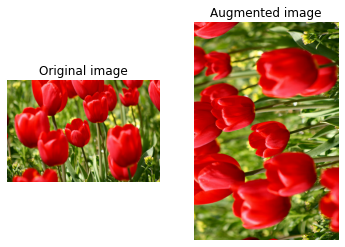

In [57]:
# Rotate an image by 90 degrees
rotated = tf.image.rot90(image)
visualize(image, rotated)

### Random transformations